In [361]:
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, accuracy_score, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# 1. Forcasting - LLM Time Series Forecasting vs. ARMIA / Exponantial Smoothing

## 1.1 Prepare Dataset

### LLM

'ALL_FORECAST.csv' contains price predicted by DeepSeek R1. LLM Input is 30 days worth of price data for each next day predicted price.

In [102]:
df = pd.read_csv('ALL_FORECAST.csv')
df

,estimated_price,last_date,last_close,estimated_date,ticker
0,244.50,2024-04-02,243.739365,2024-04-03,ADP
1,242.50,2024-04-03,241.249420,2024-04-04,ADP
2,236.78,2024-04-04,237.667038,2024-04-05,ADP
3,242.50,2024-04-05,240.973862,2024-04-08,ADP
4,243.50,2024-04-08,242.735519,2024-04-09,ADP
...,...,...,...,...,...
22493,109.50,2025-02-07,108.889999,2025-02-10,XOM
22494,110.50,2025-02-10,109.986206,2025-02-11,XOM
22495,111.20,2025-02-11,110.680000,2025-02-12,XOM
22496,108.20,2025-02-12,107.349998,2025-02-13,XOM


### ARIMA

In [103]:
def arima_forecasts(df, window=30, order=(3, 1, 0)):
    rows = []

    for ticker, g in df.groupby("ticker"):
        g = g.sort_values("last_date").reset_index(drop=True)

        closes = g["last_close"].values
        dates  = g["last_date"].values

        for i in range(window, len(g)):
            train_y = closes[i-window:i]

            model   = ARIMA(train_y, order=order)
            y_hat   = model.fit().forecast(steps=1)[0]

            data = {
                "ticker"         : ticker,
                "last_date"      : dates[i-1],   # yesterday
                "last_close"     : closes[i-1],  # yesterday’s close
                "estimated_date" : dates[i],     # today
                "estimated_price": y_hat
            }

            rows.append(data)

    return pd.DataFrame(rows)

In [104]:
arima_df = arima_forecasts(df)

/Users/taehokim/Coding/llm-ls-equity/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/taehokim/Coding/llm-ls-equity/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/taehokim/Coding/llm-ls-equity/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Exponential Smoothing

In [171]:
def ses_forecasts(df, window=30, alpha=None):
    """
    Walk-forward one-day-ahead forecasts with Simple Exponential Smoothing.

    Parameters
    ----------
    df : DataFrame
        Must contain 'ticker', 'last_date', 'last_close' columns.
        Dates stay as plain strings.
    window : int, default 30
        How many past closes each fit sees (same as ARIMA window).
    alpha : float in (0,1] or None
        Smoothing level.  If None, statsmodels chooses the
        alpha that minimises in-sample SSE for each rolling fit.

    Returns
    -------
    DataFrame with columns
        ticker | last_date | last_close | estimated_date | estimated_price | model
    """
    rows = []

    for ticker, g in df.groupby("ticker"):
        g = g.sort_values("last_date").reset_index(drop=True)
        closes = g["last_close"].values.astype(float)
        dates  = g["last_date"].values          # remain strings

        # walk forward: yesterday = index t, predict index t+1
        for t in range(window, len(closes) - 1):
            train_y = closes[t - window : t]    # previous `window` closes

            model  = SimpleExpSmoothing(train_y, initialization_method="estimated")
            fitted = model.fit(smoothing_level=alpha, optimized=(alpha is None))
            y_hat  = float(fitted.forecast(1)[0])

            data = {
                "ticker"         : ticker,
                "last_date"      : dates[t],      # yesterday (known)
                "last_close"     : closes[t],
                "estimated_date" : dates[t + 1],  # today  (predicted)
                "estimated_price": y_hat,
                "model"          : "SES"
            }
            
            rows.append(data)

    return pd.DataFrame(rows)

In [172]:
ses_df = ses_forecasts(df)

## 1.2 Evaluation

To compute accuracy, and F1-score, we introduce binary labels

\begin{cases}
1 & \text{if } P_t \;>\; P_{t-1} \\[6pt]
0 & \text{otherwise}
\end{cases}

### LLM

In [107]:
df = df.sort_values(["ticker", "last_date"]).copy()

df["actual_close"] = df.groupby("ticker")["last_close"].shift(-1)

df = df.dropna(subset=["actual_close"])

# binary labels
df["actual_up"] = (df["actual_close"] > df["last_close"]).astype(int)
df["pred_up"]   = (df["estimated_price"] > df["last_close"]).astype(int)

### ARIMA

In [109]:
arima_df = arima_df.sort_values(["ticker", "last_date"]).copy()

arima_df["actual_close"] = arima_df.groupby("ticker")["last_close"].shift(-1)

arima_df = arima_df.dropna(subset=["actual_close"])

arima_df["actual_up"] = (arima_df["actual_close"] > arima_df["last_close"]).astype(int)
arima_df["pred_up"]   = (arima_df["estimated_price"] > arima_df["last_close"]).astype(int)

### Exponential Soothing

In [173]:
ses_df = ses_df.sort_values(["ticker", "last_date"]).copy()

ses_df["actual_close"] = ses_df.groupby("ticker")["last_close"].shift(-1)

ses_df = ses_df.dropna(subset=["actual_close"])

ses_df["actual_up"] = (ses_df["actual_close"] > ses_df["last_close"]).astype(int)
ses_df["pred_up"]   = (ses_df["estimated_price"] > ses_df["last_close"]).astype(int)

### 1.2.1 Accuracy

### LLM

In [390]:
acc_by_ticker_llm = (
    df.groupby("ticker")[["actual_up", "pred_up"]]
      .apply(lambda g: accuracy_score(g["actual_up"], g["pred_up"]),
            include_groups=False)
      .rename("accuracy")
      .reset_index()
)
acc_by_ticker_llm['accuracy'].std()

0.03427944140694705

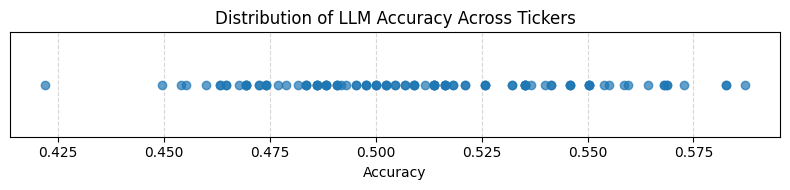

In [379]:
plt.figure(figsize=(8, 2))
plt.plot(acc_by_ticker_llm["accuracy"], [1]*len(acc_by_ticker_llm), 'o', alpha=0.7)
plt.yticks([])  # Remove y-axis ticks
plt.xlabel("Accuracy")
plt.title("Distribution of LLM Accuracy Across Tickers")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [387]:
overall_acc_llm = accuracy_score(df["actual_up"], df["pred_up"])
print(f"Overall Accuracy (LLM): {overall_acc_llm:.4f}")

Overall Accuracy (LLM): 0.5100


### ARIMA

In [389]:
acc_by_ticker_arima = (
    arima_df.groupby("ticker")[["actual_up", "pred_up"]]
      .apply(lambda g: accuracy_score(g["actual_up"], g["pred_up"]),
            include_groups=False)
      .rename("accuracy")
      .reset_index()
)
acc_by_ticker_arima['accuracy'].std()

0.03520954754117428

In [383]:
overall_acc_arima = accuracy_score(arima_df["actual_up"], arima_df["pred_up"])
print(f"Overall Accuracy (ARIMA): {overall_acc_arima:.4f}")

Overall Accuracy (ARIMA): 0.4974


### Exponential Smoothing

In [392]:
acc_by_ticker_ses = (
    ses_df.groupby("ticker")[["actual_up", "pred_up"]]
      .apply(lambda g: accuracy_score(g["actual_up"], g["pred_up"]),
            include_groups=False)
      .rename("accuracy")
      .reset_index()
)
acc_by_ticker_ses['accuracy'].std()

0.034581082207362425

In [384]:
overall_acc_ses = accuracy_score(ses_df["actual_up"], ses_df["pred_up"])
print(f"Overall Accuracy (Exponential Smoothing): {overall_acc_ses:.4f}")

Overall Accuracy (Exponential Smoothing): 0.4989


In [380]:
acc_by_ticker_llm['model'] = 'LLM'
acc_by_ticker_arima['model'] = 'ARIMA'
acc_by_ticker_ses['model'] = 'SES'

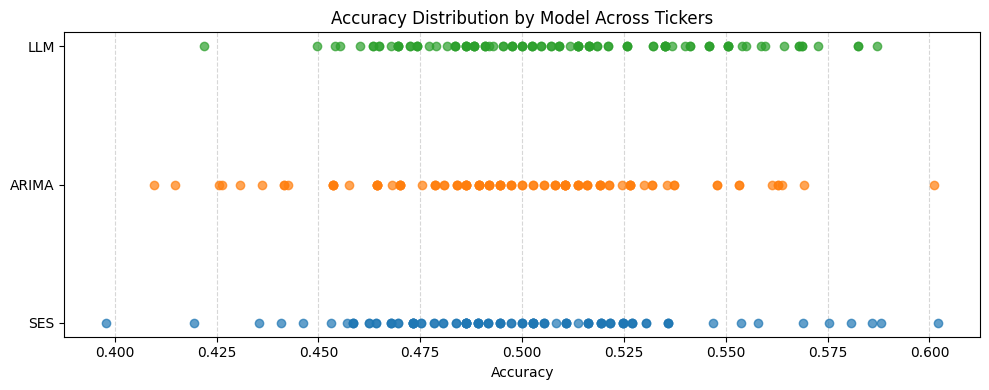

In [382]:
df_all = pd.concat([acc_by_ticker_llm, acc_by_ticker_arima, acc_by_ticker_ses], ignore_index=True)

model_order = ['SES', 'ARIMA', 'LLM']
model_to_y = {model: i for i, model in enumerate(model_order)}

plt.figure(figsize=(10, 4))
for model in model_order:
    model_data = df_all[df_all["model"] == model]
    y = [model_to_y[model]] * len(model_data)
    plt.plot(model_data["accuracy"], y, 'o', label=model, alpha=0.7)

plt.yticks(range(len(model_order)), model_order)
plt.xlabel("Accuracy")
plt.title("Accuracy Distribution by Model Across Tickers")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("accuracy_comparison.png", dpi=300)  # Save as high-resolution PNG
plt.show()

### 1.2.2 F1-score

### LLM

In [416]:
scores_result_llm = (
    df.groupby("ticker")
      .apply(lambda g: f1_score(g["actual_up"], g["pred_up"]),
            include_groups=False)
      .rename("f1_score")
      .reset_index()
)
scores_result_llm['model'] = 'LLM'
scores_result_llm['f1_score'].std()

0.05352183433751366

In [410]:
overall_f1_llm = f1_score(df["actual_up"], df["pred_up"])
print(f"Overall F1 score (LLM): {overall_f1_llm:.4f}")

Overall F1 score (LLM): 0.5891


### ARIMA

In [415]:
scores_result_arima = (
    arima_df.groupby("ticker")
      .apply(lambda g: f1_score(g["actual_up"], g["pred_up"]),
            include_groups=False)
      .rename("f1_score")
      .reset_index()
)
scores_result_arima['model'] = 'ARIMA'
scores_result_arima

,ticker,f1_score,model
0,AAPL,0.517413,ARIMA
1,ABBV,0.540816,ARIMA
2,ABNB,0.538071,ARIMA
3,ABT,0.543590,ARIMA
4,ACN,0.490000,ARIMA
...,...,...,...
99,PYPL,0.543590,ARIMA
100,SCHW,0.532020,ARIMA
101,SOFI,0.536585,ARIMA
102,T,0.535354,ARIMA


In [411]:
overall_f1_arima = f1_score(arima_df["actual_up"], arima_df["pred_up"])
print(f"Overall F1 score (ARIMA): {overall_f1_arima:.4f}")

Overall F1 score (ARIMA): 0.5200


### Exponential Smoothing

In [413]:
scores_result_ses = (
    ses_df.groupby("ticker")
      .apply(lambda g: f1_score(g["actual_up"], g["pred_up"]),
            include_groups=False)
      .rename("f1_score")
      .reset_index()
)
scores_result_ses['model'] = 'SES'
scores_result_ses

,ticker,f1_score,model
0,AAPL,0.494624,SES
1,ABBV,0.508108,SES
2,ABNB,0.582011,SES
3,ABT,0.489130,SES
4,ACN,0.491979,SES
...,...,...,...
99,PYPL,0.536842,SES
100,SCHW,0.483871,SES
101,SOFI,0.456522,SES
102,T,0.443182,SES


In [409]:
overall_f1_ses = f1_score(ses_df["actual_up"], ses_df["pred_up"])
print(f"Overall F1 score (SES): {overall_f1_ses:.4f}")

Overall F1 score (SES): 0.4964


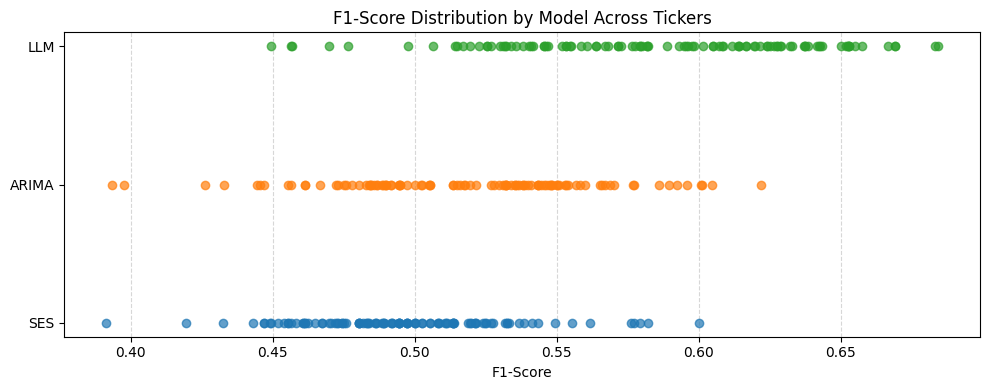

In [407]:
df_all = pd.concat([scores_result_llm, scores_result_arima, scores_result_ses], ignore_index=True)

model_order = ['SES', 'ARIMA', 'LLM']
model_to_y = {model: i for i, model in enumerate(model_order)}

plt.figure(figsize=(10, 4))
for model in model_order:
    model_data = df_all[df_all["model"] == model]
    y = [model_to_y[model]] * len(model_data)
    plt.plot(model_data["f1_score"], y, 'o', label=model, alpha=0.7)

plt.yticks(range(len(model_order)), model_order)
plt.xlabel("F1-Score")
plt.title("F1-Score Distribution by Model Across Tickers")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("f1_comparison.png", dpi=300)  # Save as high-resolution PNG
plt.show()

### 1.2.3 MAPE (Mean Average Percentage Error)

### LLM

In [418]:
mape_by_ticker_llm = (
    df.groupby("ticker")[["actual_close", "estimated_price"]]
      .apply(lambda g: mean_absolute_percentage_error(
                         g["actual_close"], g["estimated_price"]),
             include_groups=False)
      .rename("MAPE")                  # fraction (e.g. 0.045 → 4.5 %)
      .reset_index()
)
mape_by_ticker_llm['model'] = 'LLM'
mape_by_ticker_llm

,ticker,MAPE,model
0,AAPL,0.012707,LLM
1,ABBV,0.012412,LLM
2,ABNB,0.017208,LLM
3,ABT,0.009922,LLM
4,ACN,0.011538,LLM
...,...,...,...
99,PYPL,0.017851,LLM
100,SCHW,0.012602,LLM
101,SOFI,0.028747,LLM
102,T,0.010089,LLM


In [425]:
overall_mape_llm= mean_absolute_percentage_error(
                         df["actual_close"],
                         df["estimated_price"])
print(f"Overall MAPE (LLM): {overall_mape_llm*100:.3f}%")

Overall MAPE (LLM): 1.470%


### ARIMA

In [430]:
mape_by_ticker_arima = (
    df.groupby("ticker")[["actual_close", "estimated_price"]]
      .apply(lambda g: mean_absolute_percentage_error(
                         g["actual_close"], g["estimated_price"]),
             include_groups=False)
      .rename("MAPE")                  # fraction (e.g. 0.045 → 4.5 %)
      .reset_index()
)
mape_by_ticker_arima['model'] = 'ARIMA'
mape_by_ticker_arima['MAPE'].std()

0.005954522081667405

In [424]:
overall_mape_arima= mean_absolute_percentage_error(
                         arima_df["actual_close"],
                         arima_df["estimated_price"])
print(f"Overall MAPE (ARIMA): {overall_mape_arima*100:.3f}%")

Overall MAPE (ARIMA): 1.402%


### Exponential Smoothing

In [427]:
mape_by_ticker_ses = (
    ses_df.groupby("ticker")[["actual_close", "estimated_price"]]
      .apply(lambda g: mean_absolute_percentage_error(
                         g["actual_close"], g["estimated_price"]),
             include_groups=False)
      .rename("MAPE")                  # fraction (e.g. 0.045 → 4.5 %)
      .reset_index()
)
mape_by_ticker_ses['model'] = 'SES'
mape_by_ticker_ses

,ticker,MAPE,model
0,AAPL,0.016094,SES
1,ABBV,0.016335,SES
2,ABNB,0.019388,SES
3,ABT,0.013068,SES
4,ACN,0.015602,SES
...,...,...,...
99,PYPL,0.023004,SES
100,SCHW,0.019279,SES
101,SOFI,0.037948,SES
102,T,0.013912,SES


In [423]:
overall_mape_ses = mean_absolute_percentage_error(
                         ses_df["actual_close"],
                         ses_df["estimated_price"])
print(f"Overall MAPE (Exponential Smoothing): {overall_mape_ses*100:.3f}%")

Overall MAPE (Exponential Smoothing): 1.918%


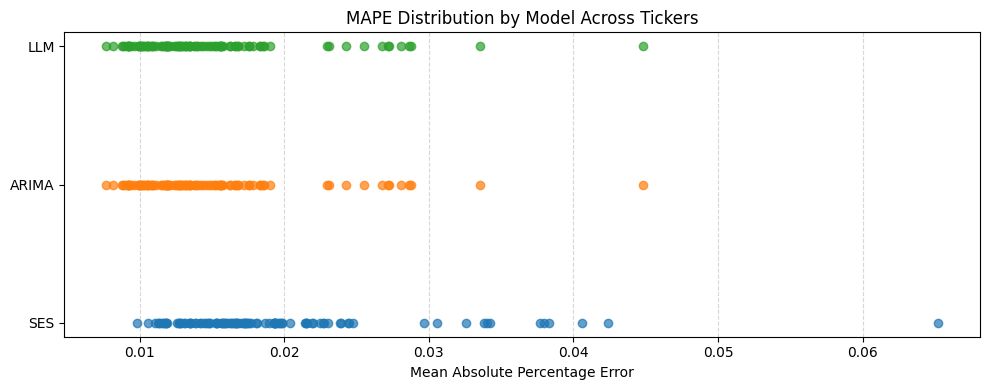

In [422]:
df_all = pd.concat([mape_by_ticker_llm, mape_by_ticker_arima, mape_by_ticker_ses], ignore_index=True)

model_order = ['SES', 'ARIMA', 'LLM']
model_to_y = {model: i for i, model in enumerate(model_order)}

plt.figure(figsize=(10, 4))
for model in model_order:
    model_data = df_all[df_all["model"] == model]
    y = [model_to_y[model]] * len(model_data)
    plt.plot(model_data["MAPE"], y, 'o', label=model, alpha=0.7)

plt.yticks(range(len(model_order)), model_order)
plt.xlabel("Mean Absolute Percentage Error")
plt.title("MAPE Distribution by Model Across Tickers")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("mape_comparison.png", dpi=300)  # Save as high-resolution PNG
plt.show()

### 1.2.3.1 MAPE for TP

In [270]:
tp_llm_df = df[df['actual_up'] == df['pred_up']]
tp_arima_df = arima_df[arima_df['actual_up'] == arima_df['pred_up']]
tp_ses_df = ses_df[ses_df['actual_up'] == ses_df["pred_up"]]

In [431]:
tp_ses_df

,ticker,last_date,last_close,estimated_date,estimated_price,model,actual_close,actual_up,pred_up
5,AAPL,2024-05-21,191.916473,2024-05-22,190.609421,SES,190.469742,0,0
7,AAPL,2024-05-23,186.458801,2024-05-24,190.469742,SES,189.551804,1,1
15,AAPL,2024-06-05,195.428528,2024-06-06,193.911957,SES,194.041656,0,0
16,AAPL,2024-06-06,194.041656,2024-06-07,195.428528,SES,196.446243,1,1
17,AAPL,2024-06-07,196.446243,2024-06-10,194.042996,SES,192.684723,0,0
...,...,...,...,...,...,...,...,...,...
19162,XOM,2025-01-31,106.830002,2025-02-03,109.396563,SES,107.089996,1,1
19163,XOM,2025-02-03,107.089996,2025-02-04,107.509921,SES,109.959999,1,1
19164,XOM,2025-02-04,109.959999,2025-02-05,107.207955,SES,109.879997,0,0
19165,XOM,2025-02-05,109.879997,2025-02-06,109.068492,SES,108.430000,0,0


### LLM

In [272]:
overall_mape_llm_tp = mean_absolute_percentage_error(
                         tp_llm_df["actual_close"],
                         tp_llm_df["estimated_price"])
print(f"Overall MAPE for TP (LLM): {overall_mape_llm_tp*100:.10f}%")

Overall MAPE for TP (LLM): 0.9021395268%


### ARIMA

In [274]:
overall_mape_arima_tp = mean_absolute_percentage_error(
                         tp_arima_df["actual_close"],
                         tp_arima_df["estimated_price"])
print(f"Overall MAPE (ARIMA): {overall_mape_arima_tp*100:.10f}%")

Overall MAPE (ARIMA): 1.0369925516%


### Exponential Smoothing

In [275]:
overall_mape_ses_tp = mean_absolute_percentage_error(
                         tp_ses_df["actual_close"],
                         tp_ses_df["estimated_price"])
print(f"Overall MAPE (ARIMA): {overall_mape_ses_tp*100:.10f}%")

Overall MAPE (ARIMA): 1.2038351323%


### 1.2.4 Evaluation Based on Price Volatility

$$
\sigma_{\text{vol}}(k)
\;=\;
\sqrt{
  \dfrac{1}{T-1}\,
  \sum_{t=2}^{T}
    \bigl(\ln P_{k,t}-\ln P_{k,t-1}\bigr)^2
}
$$

In [438]:
dfff = df.copy()
dfff['log_return'] = dfff.groupby('ticker')['last_close'].transform(lambda x: np.log(x) - np.log(x.shift(1)))

vol_df = (
    dfff.groupby('ticker')['log_return']
    .std()
    .reset_index()
    .rename(columns={'log_return': 'price_volatility'})
)

vol_df = vol_df.sort_values(by='price_volatility', ascending=False)

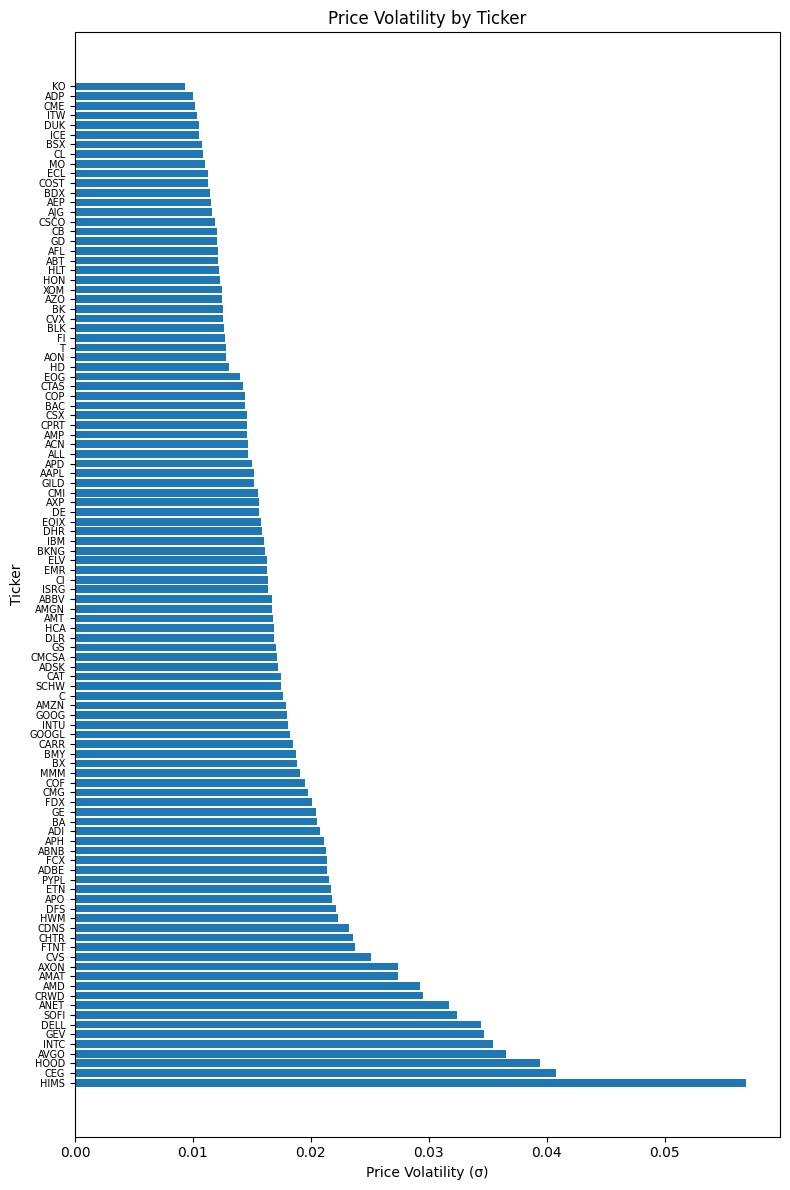

In [441]:
plt.figure(figsize=(8, 12))
ax = plt.gca()

# Horizontal bar chart
ax.barh(vol_df['ticker'], vol_df['price_volatility'])

# Make ticker labels smaller
ax.tick_params(axis='y', labelsize=7)

plt.xlabel("Price Volatility (σ)")
plt.ylabel("Ticker")
plt.title("Price Volatility by Ticker")
plt.tight_layout()
plt.savefig("price_volatility.png", dpi=300) 
plt.show()

In [209]:
def flag_volatility(df, cutoff):
    """
    Compute σ(log-returns) per ticker and append a 'vol_bucket' column:
        'HighVol'  if σ >= cutoff
        'LowVol'   otherwise
    cutoff can be 'median', a percentile (e.g. 0.75), or a numeric σ.
    """
    df_sorted = df.sort_values(["ticker", "last_date"])
    log_ret   = np.log(df_sorted.groupby("ticker")["last_close"].pct_change() + 1)

    sigma_tbl = (
        log_ret.groupby(df_sorted["ticker"])
               .std()                          # std of log-returns
               .rename("sigma")
               .reset_index()
    )

    if cutoff == "median":
        thr = sigma_tbl["sigma"].median()
    elif 0 < cutoff < 1:
        thr = sigma_tbl["sigma"].quantile(cutoff)
    else:
        thr = float(cutoff)

    sigma_tbl["vol_bucket"] = np.where(
        sigma_tbl["sigma"] >= thr, "HighVol", "LowVol"
    )

    return df.merge(sigma_tbl, on="ticker", how="left")

In [219]:
def bucket_scores(pred_df):
    return (
        pred_df.groupby("vol_bucket")
               .apply(lambda g: pd.Series({
                   "Accuracy": accuracy_score(g["actual_up"], g["pred_up"]),
                   "F1"      : f1_score     (g["actual_up"], g["pred_up"]),
                   "MAPE"    : mean_absolute_percentage_error(
                                   g["actual_close"], g["estimated_price"])
               }), include_groups=False)
               .reset_index()
    )

### LLM

In [220]:
llm_df_tagged = flag_volatility(df, 0.8)

scores_by_bucket_llm = bucket_scores(llm_df_tagged)
print(scores_by_bucket_llm)

  vol_bucket  Accuracy        F1      MAPE
0    HighVol  0.492325  0.569921  0.023624
1     LowVol  0.514386  0.593908  0.012460


### ARIMA

In [221]:
arima_df_tagged = flag_volatility(arima_df, 0.8)

scores_by_bucket_arima = bucket_scores(arima_df_tagged)
print(scores_by_bucket_arima)

  vol_bucket  Accuracy        F1      MAPE
0    HighVol  0.493677  0.518409  0.022943
1     LowVol  0.498279  0.520363  0.011770


### Exponential Smoothing

In [222]:
ses_df_tagged = flag_volatility(ses_df, 0.8)

scores_by_bucket_ses = bucket_scores(ses_df_tagged)
print(scores_by_bucket_ses)

  vol_bucket  Accuracy        F1      MAPE
0    HighVol  0.499348  0.496722  0.031602
1     LowVol  0.498786  0.496272  0.016056


## 2. News Sentiment Analysis 

### 2.1 Sentiment Scoring - Analyzing Price Movements

Let's observe the data we retrieved using an LLM.

In [295]:
sentiment_df = pd.read_csv('SENTIMENT_SCORING.csv')

In [298]:
sentiment_df.head()

,score,confidence,reason,ticker,headline,summary,date
0,5,Low,irrelevant headline and summary for AAPL,AAPL,TSLA Stock Analysis: Is Tesla’s Astronomical V...,Looking for stock market analysis and research...,2024-02-20
1,5,Low,"irrelevant summary, no meaningful content",AAPL,Apple said to change audio leadership: report,Looking for stock market analysis and research...,2024-02-20
2,5,Low,"""single source, neutral tone, unclear relevanc...",AAPL,"ETO: Maintaining Rating, But This Global CEF I...",ETO appears to be fully covering its distribut...,2024-02-20
3,6,Medium,"single source, speculative product news with m...",AAPL,"Apple's Foldable iPhone To Launch In 2026, Eig...",Looking for stock market analysis and research...,2024-02-20
4,5,Low,"irrelevant summary, no meaningful content abou...",AAPL,Vision Pro $199 Travel Case Has The Internet D...,Looking for stock market analysis and research...,2024-02-20


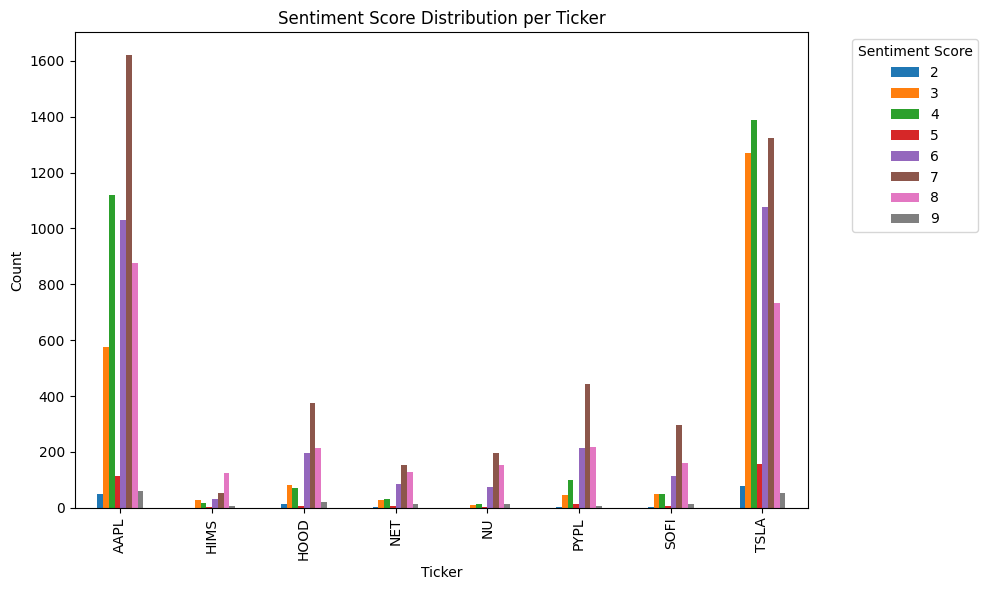

In [452]:

score_counts = sentiment_df[sentiment_df['confidence'] != 'Low'].groupby(['ticker', 'score']).size().unstack(fill_value=0)

score_counts.plot(kind='bar', figsize=(10, 6))

plt.title('Sentiment Score Distribution per Ticker')
plt.xlabel('Ticker')
plt.ylabel('Count')
plt.legend(title='Sentiment Score', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('sentiment_score_distribution.png', dpi=300)
plt.show()

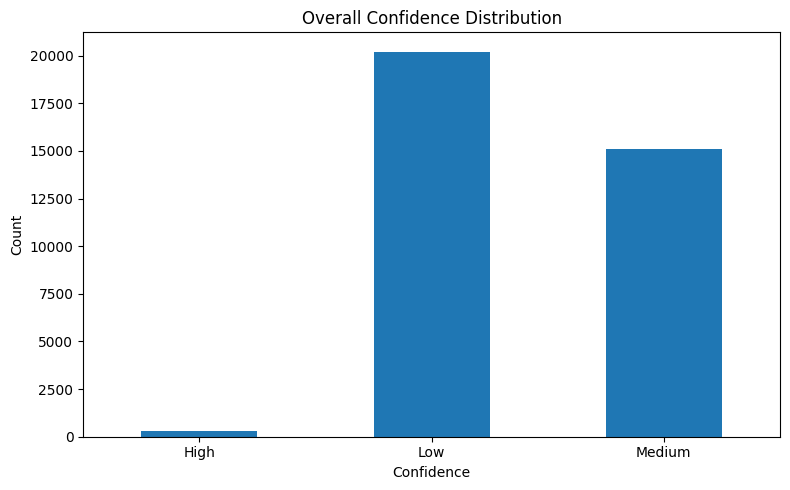

In [451]:
score_counts = sentiment_df['confidence'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
score_counts.plot(kind='bar')

plt.title('Overall Confidence Distribution')
plt.xlabel('Confidence')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('sentiment_confidence_distribution.png', dpi=300)
plt.show()

Let's see how much noise we have in the data. (i.e. Output where LLM has low confidence.)

In [337]:
confidence_counts = (
    pd.crosstab(                      
        sentiment_df["ticker"],
        sentiment_df["confidence"],
        dropna=False,
    )
    .reindex(columns=["Low", "Medium", "High"], fill_value=0)
    .astype(int)
    .sort_index()
)

print(confidence_counts)

confidence   Low  Medium  High
ticker                        
AAPL        8530    5348    96
HIMS         334     255    11
HOOD         921     938    38
NET          468     424    23
NU           264     450    10
PYPL        1077    1029    13
SOFI         597     684    12
TSLA        8026    5986    98


For our analysis, we ignore sentiment score data with low conficence.

In [338]:
sentiment_df_confident = sentiment_df[sentiment_df['confidence'] != 'Low']

In [339]:
price_data = pd.read_csv("./stock_price_history.csv")        
price_data['date'] = pd.to_datetime(price_data['date'], errors='coerce')
price_data.sort_values('date', ascending=True, inplace=True)
price_data.drop(columns=['uuid', 'open', 'high', 'low', 'stock_splits', 'dividends'], inplace=True)
price_data['date'] = price_data['date'].dt.strftime("%Y-%m-%d")

We now want to see how sentiment score trend compares to the price changes

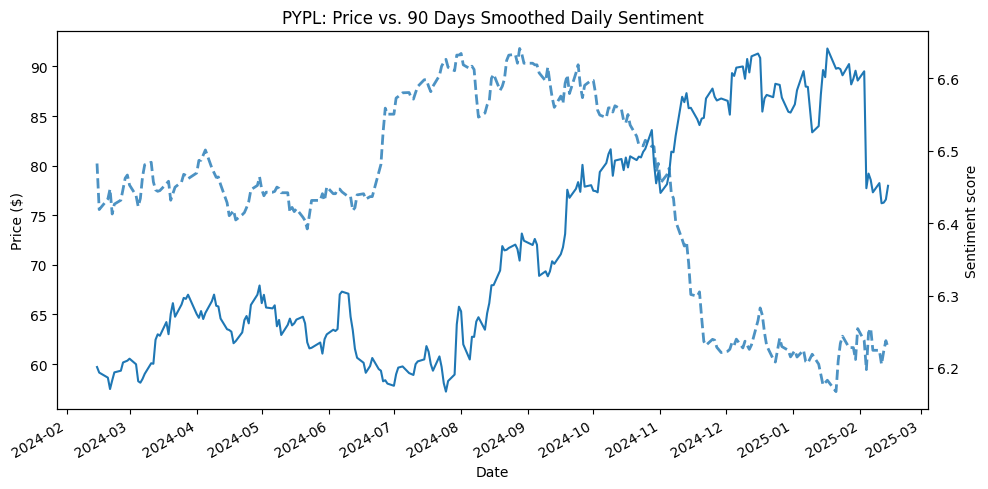

In [453]:
ticker = "PYPL"
WINDOW = 90

sent = (sentiment_df_confident[sentiment_df_confident["ticker"] == ticker]
        .groupby("date", as_index=False)["score"]
        .mean()
        .rename(columns={"date": "trade_date"})
       )

px = (price_data[price_data["ticker"] == ticker]
      .rename(columns={"date": "trade_date",
                       "close": "close"})
      .sort_values("trade_date")
     )

data = px.merge(sent, on="trade_date", how="left")

data["score_smooth"] = (
    data["score"]
      .rolling(window=WINDOW, center=True, min_periods=1)
      .mean()
)

data["trade_date"] = pd.to_datetime(data["trade_date"])

# ---------------------------------------------------------------
# plot
# ---------------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(data["trade_date"], data["close"], label="Close price")
ax1.set_xlabel("Date")
ax1.set_ylabel("Price ($)")
ax1.set_title(f"{ticker}: Price vs. 90 Days Smoothed Daily Sentiment")

ax2 = ax1.twinx()
ax2.plot(data["trade_date"], data["score_smooth"],
         linestyle="--", linewidth=2,
         label="Smoothed sentiment", alpha=0.8)
ax2.set_ylabel("Sentiment score")

ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('pypl_sentiment_score.png', dpi=300)
plt.show()

# 3. Forecasting with Sentiment Data

## 3.1 Price Forecasting

From our previous Sentiment Analysis Evalution step, we have gathered data in such form
```
{
    'score': "SENTIMENT_SCORE",
    'confidence': "High / Medium / Low",
    'date': "YYYY-MM-DD format",
    ...
}
```

Using the same price data, and using the above output, we explore if adding sentiment score data would help with price forecasting.

In [233]:
sentiment_price_llm_df = pd.read_csv('SENTIMENT_PRICE.csv')
sentiment_price_llm_df

,estimated_price,last_date,last_close,estimated_date,ticker
0,7.15,2024-04-02,7.200000,2024-04-03,SOFI
1,7.45,2024-04-03,7.540000,2024-04-04,SOFI
2,7.25,2024-04-04,7.310000,2024-04-05,SOFI
3,7.35,2024-04-05,7.400000,2024-04-08,SOFI
4,7.85,2024-04-08,7.760000,2024-04-09,SOFI
...,...,...,...,...,...
1090,76.45,2025-02-07,77.309998,2025-02-10,PYPL
1091,78.50,2025-02-10,78.239998,2025-02-11,PYPL
1092,75.40,2025-02-11,76.209999,2025-02-12,PYPL
1093,75.46,2025-02-12,76.269997,2025-02-13,PYPL


#### Binary Labeling

In [235]:
sentiment_price_llm_df = sentiment_price_llm_df.sort_values(["ticker", "last_date"]).copy()

sentiment_price_llm_df["actual_close"] = sentiment_price_llm_df.groupby("ticker")["last_close"].shift(-1)

sentiment_price_llm_df = sentiment_price_llm_df.dropna(subset=["actual_close"])

# binary labels
sentiment_price_llm_df["actual_up"] = (sentiment_price_llm_df["actual_close"] > sentiment_price_llm_df["last_close"]).astype(int)
sentiment_price_llm_df["pred_up"]   = (sentiment_price_llm_df["estimated_price"] > sentiment_price_llm_df["last_close"]).astype(int)

In [248]:
llm_df_subset = df[df['ticker'].isin(acc_by_ticker_sentiment_llm['ticker'])]

### 3.1 Accuracy

In [239]:
acc_by_ticker_sentiment_llm = (
    sentiment_price_llm_df.groupby("ticker")[["actual_up", "pred_up"]]
      .apply(lambda g: accuracy_score(g["actual_up"], g["pred_up"]),
            include_groups=False)
      .rename("accuracy")
      .reset_index()
)
acc_by_ticker_sentiment_llm

,ticker,accuracy
0,AAPL,0.550459
1,HIMS,0.536697
2,HOOD,0.536697
3,PYPL,0.486239
4,SOFI,0.449541


In [454]:
overall_acc_sentiment_llm  = accuracy_score(sentiment_price_llm_df["actual_up"], sentiment_price_llm_df["pred_up"])
print(f"Overall Accuracy (LLM with sentiment): {overall_acc_sentiment_llm:.4}")

Overall Accuracy (LLM with sentiment): 0.5119


Compare this result with the earlier result where no sentiment data was provided

In [245]:
acc_by_ticker_llm_subset = acc_by_ticker_llm[acc_by_ticker_llm['ticker'].isin(acc_by_ticker_sentiment_llm['ticker'])]
acc_by_ticker_llm_subset

,ticker,accuracy
0,AAPL,0.545872
85,HIMS,0.550459
88,HOOD,0.518349
99,PYPL,0.463303
101,SOFI,0.422018


In [455]:
overall_acc_llm_subset  = accuracy_score(llm_df_subset["actual_up"], llm_df_subset["pred_up"])
print(f"Overall Accuracy (LLM): {overall_acc_llm_subset:.4f}")

Overall Accuracy (LLM): 0.5000


### F1 Score

In [254]:
scores_result_llm_sentiment = (
    sentiment_price_llm_df.groupby("ticker")
      .apply(lambda g: f1_score(g["actual_up"], g["pred_up"]),
            include_groups=False)
      .rename("f1_score")
      .reset_index()
)
scores_result_llm_sentiment

,ticker,f1_score
0,AAPL,0.662069
1,HIMS,0.594378
2,HOOD,0.655290
3,PYPL,0.582090
4,SOFI,0.491525


In [456]:
overall_f1_llm_sentiment = f1_score(sentiment_price_llm_df["actual_up"], sentiment_price_llm_df["pred_up"])
print(f"Overall F1 score (LLM): {overall_f1_llm_sentiment:.4f}")

Overall F1 score (LLM): 0.6018


In [251]:
scores_result_llm_subset = (
    llm_df_subset.groupby("ticker")
      .apply(lambda g: f1_score(g["actual_up"], g["pred_up"]),
            include_groups=False)
      .rename("f1_score")
      .reset_index()
)
scores_result_llm_subset

,ticker,f1_score
0,AAPL,0.657439
1,HIMS,0.614173
2,HOOD,0.641638
3,PYPL,0.558491
4,SOFI,0.456897


In [457]:
overall_f1_llm_subset = f1_score(llm_df_subset["actual_up"], llm_df_subset["pred_up"])
print(f"Overall F1 score (LLM): {overall_f1_llm_subset:.4f}")

Overall F1 score (LLM): 0.5911


### MAPE

In [249]:
mape_by_ticker_llm_sentiment = (
    sentiment_price_llm_df.groupby("ticker")[["actual_close", "estimated_price"]]
      .apply(lambda g: mean_absolute_percentage_error(
                         g["actual_close"], g["estimated_price"]),
             include_groups=False)
      .rename("MAPE")
      .reset_index()
)
mape_by_ticker_llm_sentiment

,ticker,MAPE
0,AAPL,0.012275
1,HIMS,0.044727
2,HOOD,0.032941
3,PYPL,0.017679
4,SOFI,0.028304


In [458]:
overall_mape_llm_sentiment = mean_absolute_percentage_error(
                         sentiment_price_llm_df["actual_close"],
                         sentiment_price_llm_df["estimated_price"])
print(f"Overall MAPE (LLM with sentiment): {overall_mape_llm_sentiment*100:.3f}%")

Overall MAPE (LLM with sentiment): 2.718%


In [250]:
mape_by_ticker_llm_subset = (
    llm_df_subset.groupby("ticker")[["actual_close", "estimated_price"]]
      .apply(lambda g: mean_absolute_percentage_error(
                         g["actual_close"], g["estimated_price"]),
             include_groups=False)
      .rename("MAPE")                  # fraction (e.g. 0.045 → 4.5 %)
      .reset_index()
)
mape_by_ticker_llm_subset

,ticker,MAPE
0,AAPL,0.012707
1,HIMS,0.044803
2,HOOD,0.033532
3,PYPL,0.017851
4,SOFI,0.028747


In [459]:
overall_mape_llm_subset = mean_absolute_percentage_error(
                         llm_df_subset["actual_close"],
                         llm_df_subset["estimated_price"])
print(f"Overall MAPE (LLM): {overall_mape_llm_subset*100:.3f}%")

Overall MAPE (LLM): 2.753%


In [255]:
llm_df_subset_tagged = flag_volatility(llm_df_subset, 0.6)

scores_by_bucket_llm_subset = bucket_scores(llm_df_subset_tagged)
print(scores_by_bucket_llm_subset)

  vol_bucket  Accuracy        F1      MAPE
0    HighVol  0.534404  0.628885  0.039167
1     LowVol  0.477064  0.564885  0.019768


In [256]:
llm_df_sentiment_tagged = flag_volatility(sentiment_price_llm_df, 0.6)

scores_by_bucket_llm_sentiment = bucket_scores(llm_df_sentiment_tagged)
print(scores_by_bucket_llm_sentiment)

  vol_bucket  Accuracy        F1      MAPE
0    HighVol  0.536697  0.627306  0.038834
1     LowVol  0.495413  0.584383  0.019419


In [467]:
sentiment_price_llm_df['model'] = 'LLM-SENTIMENT'
df['model'] = 'LLM'

In [468]:
arima_df['model'] = 'ARIMA'

In [469]:
ses_df['model'] = 'SES'

In [470]:
ses_df

,ticker,last_date,last_close,estimated_date,estimated_price,model,actual_close,actual_up,pred_up
0,AAPL,2024-05-14,187.007553,2024-05-15,185.860153,SES,189.292404,1,0
1,AAPL,2024-05-15,189.292404,2024-05-16,187.007553,SES,189.412125,1,0
2,AAPL,2024-05-16,189.412125,2024-05-17,189.292404,SES,189.442062,1,0
3,AAPL,2024-05-17,189.442062,2024-05-20,189.412125,SES,190.609421,1,0
4,AAPL,2024-05-20,190.609421,2024-05-21,189.442062,SES,191.916473,1,0
...,...,...,...,...,...,...,...,...,...
19164,XOM,2025-02-04,109.959999,2025-02-05,107.207955,SES,109.879997,0,0
19165,XOM,2025-02-05,109.879997,2025-02-06,109.068492,SES,108.430000,0,0
19166,XOM,2025-02-06,108.430000,2025-02-07,109.661521,SES,108.889999,1,1
19167,XOM,2025-02-07,108.889999,2025-02-10,108.826546,SES,109.986206,1,0


In [471]:
agg_data = pd.concat([ses_df, arima_df, df, sentiment_price_llm_df])

In [472]:
agg_data

,ticker,last_date,last_close,estimated_date,estimated_price,model,actual_close,actual_up,pred_up
0,AAPL,2024-05-14,187.007553,2024-05-15,185.860153,SES,189.292404,1,0
1,AAPL,2024-05-15,189.292404,2024-05-16,187.007553,SES,189.412125,1,0
2,AAPL,2024-05-16,189.412125,2024-05-17,189.292404,SES,189.442062,1,0
3,AAPL,2024-05-17,189.442062,2024-05-20,189.412125,SES,190.609421,1,0
4,AAPL,2024-05-20,190.609421,2024-05-21,189.442062,SES,191.916473,1,0
...,...,...,...,...,...,...,...,...,...
213,SOFI,2025-02-06,14.800000,2025-02-07,15.100000,LLM-SENTIMENT,14.910000,1,1
214,SOFI,2025-02-07,14.910000,2025-02-10,15.100000,LLM-SENTIMENT,15.130000,1,1
215,SOFI,2025-02-10,15.130000,2025-02-11,15.250000,LLM-SENTIMENT,14.830000,0,1
216,SOFI,2025-02-11,14.830000,2025-02-12,14.700000,LLM-SENTIMENT,14.770000,0,0


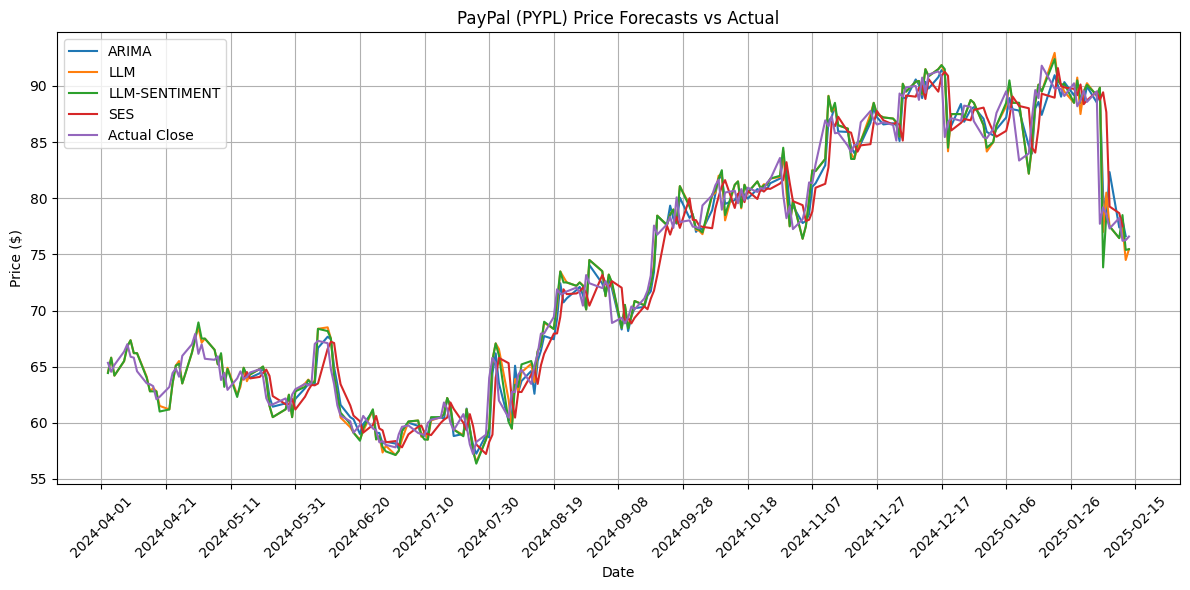

In [478]:
df_pypl = agg_data[agg_data['ticker'] == 'PYPL'].copy()

df_pypl["estimated_date"] = pd.to_datetime(df_pypl["estimated_date"])
pivot_df = df_pypl.pivot(index='estimated_date', columns='model', values='estimated_price')

# Add actual close price
pivot_df['Actual Close'] = df_pypl.groupby('estimated_date')['actual_close'].first()

# Sort by date just in case
pivot_df = pivot_df.sort_index()

# Plot
plt.figure(figsize=(12, 6))
for column in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[column], label=column)

plt.title('PayPal (PYPL) Price Forecasts vs Actual')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
# Format date ticks: show one every 5 days
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=20))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.savefig("pypl_price_comparison.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

### Testing for Pretraining Bias in Predictions

In [479]:
ticker_estimate_df = pd.read_csv('TICKER_ESTIMATE_PRICE.csv')

In [480]:
ticker_estimate_df

,estimated_ticker,last_date,last_close,estimated_date,ticker
0,VFS,2024-04-02,7.200000,2024-04-03,SOFI
1,VFS,2024-04-03,7.540000,2024-04-04,SOFI
2,RIVN,2024-04-04,7.310000,2024-04-05,SOFI
3,SOS,2024-04-05,7.400000,2024-04-08,SOFI
4,RIVN,2024-04-08,7.760000,2024-04-09,SOFI
...,...,...,...,...,...
1090,BCRX,2025-02-07,42.549999,2025-02-10,HIMS
1091,GME,2025-02-10,44.770000,2025-02-11,HIMS
1092,GME,2025-02-11,43.580002,2025-02-12,HIMS
1093,GME,2025-02-12,46.340000,2025-02-13,HIMS


In [483]:
ticker_estimate_df['correct'] = ticker_estimate_df['estimated_ticker'] == ticker_estimate_df['ticker']

accuracy_df = (
    ticker_estimate_df.groupby('ticker')['correct']
    .mean()
    .reset_index()
    .rename(columns={'correct': 'accuracy'})
)

print(accuracy_df)

  ticker  accuracy
0   AAPL  0.132420
1   HIMS  0.000000
2   HOOD  0.018265
3   PYPL  0.013699
4   SOFI  0.000000


In [484]:
overall_mean_accuracy = accuracy_df['accuracy'].mean()
print(f"Overall Mean Accuracy: {overall_mean_accuracy:.4f}")  # e.g., 0.6825

Overall Mean Accuracy: 0.0329
